In [1]:
# Partner 1: Haoting Tan  
# Partner 2: Lin Ha

In [2]:
!hdfs dfs -D dfs.replication=1 -cp -f data/*.csv hdfs://nn:9000/

In [3]:
# # use for remove all csv files
# !hdfs dfs -rm -f hdfs://nn:9000/*.csv

In [4]:
from pyspark.sql import SparkSession
spark = (SparkSession.builder.appName("cs544")
         .master("spark://boss:7077")
         .config("spark.executor.memory", "512M")
         .config("spark.sql.warehouse.dir", "hdfs://nn:9000/user/hive/warehouse")
         .enableHiveSupport()
         .getOrCreate())

Setting default log level to "WARN".
To adjust logging level use sc.setLogLevel(newLevel). For SparkR, use setLogLevel(newLevel).
23/11/06 04:27:20 WARN NativeCodeLoader: Unable to load native-hadoop library for your platform... using builtin-java classes where applicable


In [5]:
banks_df = spark.read.csv("hdfs://nn:9000/arid2017_to_lei_xref_csv.csv", header=True, inferSchema=True)

In [6]:
#q1
q1 = banks_df.rdd.filter(lambda row: "first" in row["respondent_name"].lower())
q1.count()

525

In [7]:
#q2
from pyspark.sql.functions import lower, col
q2 = banks_df.filter(lower(col("respondent_name")).contains("first"))
q2.count()

525

In [8]:
#q3
banks_df.write.saveAsTable("banks", mode="overwrite")
q3 = spark.sql("""
SELECT COUNT(*) AS count
FROM banks
WHERE LOWER(respondent_name) LIKE '%first%'
""")
q3.collect()[0][0]

23/11/06 04:27:56 WARN HiveConf: HiveConf of name hive.stats.jdbc.timeout does not exist
23/11/06 04:27:56 WARN HiveConf: HiveConf of name hive.stats.retries.wait does not exist
23/11/06 04:28:02 WARN ObjectStore: Version information not found in metastore. hive.metastore.schema.verification is not enabled so recording the schema version 2.3.0
23/11/06 04:28:02 WARN ObjectStore: setMetaStoreSchemaVersion called but recording version is disabled: version = 2.3.0, comment = Set by MetaStore UNKNOWN@172.21.0.6
23/11/06 04:28:02 WARN ObjectStore: Failed to get database default, returning NoSuchObjectException
23/11/06 04:28:05 WARN SessionState: METASTORE_FILTER_HOOK will be ignored, since hive.security.authorization.manager is set to instance of HiveAuthorizerFactory.
23/11/06 04:28:06 WARN HiveConf: HiveConf of name hive.internal.ss.authz.settings.applied.marker does not exist
23/11/06 04:28:06 WARN HiveConf: HiveConf of name hive.stats.jdbc.timeout does not exist
23/11/06 04:28:06 WARN 

525

In [9]:
loans_df = spark.read.csv("hdfs://nn:9000/hdma-wi-2021.csv", header=True, inferSchema=True)
(loans_df.write.bucketBy(8, 'county_code')
     .mode("overwrite")
     .saveAsTable('loans'))

name_list = ["ethnicity", "race", "sex", "states", "counties", "tracts", "action_taken",
 "denial_reason", "loan_type", "loan_purpose", "preapproval", "property_type"]

for name in name_list:
    df = spark.read.csv(f"hdfs://nn:9000/{name}.csv", header=True, inferSchema=True)
    df.createOrReplaceTempView(name)

23/11/06 04:28:21 WARN SparkStringUtils: Truncated the string representation of a plan since it was too large. This behavior can be adjusted by setting 'spark.sql.debug.maxToStringFields'.


In [10]:
# use for dropping the view and delete the table
# for name in name_list:
    # spark.catalog.dropTempView(name)
    # spark.sql(f'DROP TABLE {name}')  

In [11]:
#q4
output_dict = {}
for row in spark.sql("SHOW TABLES").collect():
   output_dict[row[1]] = row[2]
output_dict

{'banks': False,
 'loans': False,
 'action_taken': True,
 'counties': True,
 'denial_reason': True,
 'ethnicity': True,
 'loan_purpose': True,
 'loan_type': True,
 'preapproval': True,
 'property_type': True,
 'race': True,
 'sex': True,
 'states': True,
 'tracts': True}

In [12]:
#q5
q5 = spark.sql("""
SELECT COUNT(*) AS loan_count
FROM loans
INNER JOIN banks ON loans.lei = banks.lei_2020
WHERE banks.respondent_name = 'University of Wisconsin Credit Union' 
""")
q5.collect()[0][0]

19739

In [13]:
#q6
q5.explain("formatted")
# question 1:
# "banks" table sent to every executor via a BroadcastExchange operation.
# 
# question 2:
# Yes, the plan involves HashAggregate: partial_count() and count() 

== Physical Plan ==
AdaptiveSparkPlan (25)
+- == Final Plan ==
   * HashAggregate (15)
   +- ShuffleQueryStage (14), Statistics(sizeInBytes=32.0 B, rowCount=2)
      +- Exchange (13)
         +- * HashAggregate (12)
            +- * Project (11)
               +- * BroadcastHashJoin Inner BuildRight (10)
                  :- * Filter (3)
                  :  +- * ColumnarToRow (2)
                  :     +- Scan parquet spark_catalog.default.loans (1)
                  +- BroadcastQueryStage (9), Statistics(sizeInBytes=8.0 MiB, rowCount=1)
                     +- BroadcastExchange (8)
                        +- * Project (7)
                           +- * Filter (6)
                              +- * ColumnarToRow (5)
                                 +- Scan parquet spark_catalog.default.banks (4)
+- == Initial Plan ==
   HashAggregate (24)
   +- Exchange (23)
      +- HashAggregate (22)
         +- Project (21)
            +- BroadcastHashJoin Inner BuildRight (20)
               :- 

{'Milwaukee': 3.1173465727097907,
 'Waukesha': 2.8758225602027756,
 'Washington': 2.851009389671362,
 'Dane': 2.890674955595027,
 'Brown': 3.010949119373777,
 'Racine': 3.099783715012723,
 'Outagamie': 2.979661835748792,
 'Winnebago': 3.0284761904761908,
 'Ozaukee': 2.8673765432098772,
 'Sheboygan': 2.995511111111111}

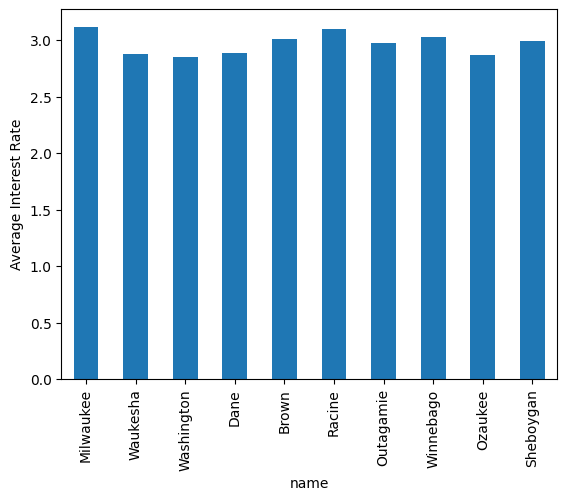

In [14]:
#q7
wells_fargo_df = spark.sql("""
SELECT *
FROM loans
INNER JOIN banks ON loans.lei = banks.lei_2020
WHERE LOWER(banks.respondent_name) LIKE '%wells fargo%'
""")
wells_fargo_df.createOrReplaceTempView('wells_fargo')

q7 = spark.sql("""
SELECT NAME, AVG(interest_rate) as avg_rt
FROM wells_fargo
LEFT JOIN counties ON INT(wells_fargo.county_code/1000) = counties.STATE AND INT(wells_fargo.county_code%1000) = counties.COUNTY
GROUP BY NAME
ORDER BY COUNT(*) DESC
LIMIT 10
""")

spark.catalog.dropTempView('wells_fargo')
output_dict = {}
for row in q7.collect():
   output_dict[row[0]] = row[1]

q7 = q7.toPandas().set_index("NAME")
q7.plot.bar(legend=None, ylabel="Average Interest Rate", xlabel="name")
output_dict


In [15]:
#q8
# Observe that there is "Exchange hashpartitioning" exists when GROUP BY lei. This occurs since we split
# the whole dataset into bucket bt county_code, so there is no Network I/O invovled there, but not lei.
# So, there is Network I/O to regroup and repartition when need to access all value of lei.
spark.sql("""
SELECT AVG(interest_rate)
FROM loans
GROUP BY county_code
""").explain()

spark.sql("""
SELECT AVG(interest_rate)
FROM loans
GROUP BY lei
""").explain()

== Physical Plan ==
AdaptiveSparkPlan isFinalPlan=false
+- HashAggregate(keys=[county_code#784], functions=[avg(cast(interest_rate#803 as double))])
   +- HashAggregate(keys=[county_code#784], functions=[partial_avg(cast(interest_rate#803 as double))])
      +- FileScan parquet spark_catalog.default.loans[county_code#784,interest_rate#803] Batched: true, Bucketed: true, DataFilters: [], Format: Parquet, Location: InMemoryFileIndex(1 paths)[hdfs://nn:9000/user/hive/warehouse/loans], PartitionFilters: [], PushedFilters: [], ReadSchema: struct<county_code:string,interest_rate:string>, SelectedBucketsCount: 8 out of 8


== Physical Plan ==
AdaptiveSparkPlan isFinalPlan=false
+- HashAggregate(keys=[lei#781], functions=[avg(cast(interest_rate#803 as double))])
   +- Exchange hashpartitioning(lei#781, 200), ENSURE_REQUIREMENTS, [plan_id=882]
      +- HashAggregate(keys=[lei#781], functions=[partial_avg(cast(interest_rate#803 as double))])
         +- FileScan parquet spark_catalog.default.loa

In [16]:
from pyspark.sql.functions import expr, when, col

action_taken_df = spark.read.csv("hdfs://nn:9000/action_taken.csv", header=True, inferSchema=True)
df = loans_df.withColumnRenamed("action_taken", "id").join(action_taken_df, 'id', 'inner')
df = df.withColumn(
    "approval",
    when(df.action_taken == 'Loan originated', 1)
    .otherwise(0)
)
df = df.select("loan_amount", "income", "interest_rate", "approval")
df = df.withColumn("loan_amount", col("loan_amount").cast("double"))
df = df.withColumn("income", col("income").cast("double"))
df = df.withColumn("interest_rate", col("interest_rate").cast("double"))
df = df.fillna(0.0)

In [17]:
train, test = df.randomSplit([0.8, 0.2], seed=41) 
train.cache()

DataFrame[loan_amount: double, income: double, interest_rate: double, approval: int]

In [18]:
#q9
train.filter(expr("approval = 1")).count() 

242855

In [19]:
#q10
from pyspark.ml.feature import VectorAssembler
from pyspark.ml.classification import DecisionTreeClassifier
from pyspark.ml.pipeline import Pipeline

va = VectorAssembler(inputCols=["loan_amount", "income", "interest_rate"], outputCol = "features")
dt = DecisionTreeClassifier(featuresCol="features", labelCol="approval", maxDepth=5)
pipe = Pipeline(stages=[va, dt])
model = pipe.fit(train)
model.transform(test).filter(expr("prediction = approval")).count() / model.transform(test).count()

0.8931228007661128

In [20]:
train.unpersist()

DataFrame[loan_amount: double, income: double, interest_rate: double, approval: int]